In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [2]:
import tensorflow.keras
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp
from scipy.interpolate import interp1d

/home/isidro/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/isidro/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/isidro/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/isidro/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dty

In [4]:
file = 'data/pantheon.txt'
syscov_file = 'data/pantheon_errors.txt'
# file = 'data/lcparam_full_long.txt'
df = pd.read_csv(file, sep = " ", usecols=['zcmb', 'mb', 'dmb'])
# df = pd.read_csv(file, sep = " ")
dmag = df[['dmb']]
df = df[['zcmb', 'mb']]
N = len(df.values)
syscov = np.loadtxt(syscov_file, skiprows=1).reshape((N, N))
cov = np.copy(syscov)

In [5]:
df.head()

,zcmb,mb
0,0.50349,22.93445
1,0.49520,22.88020
2,0.67820,24.03770
3,0.86720,24.34685
4,0.79920,24.36050


In [6]:
dmag = dmag.values.reshape(N,)
np.shape(dmag)

(1048,)

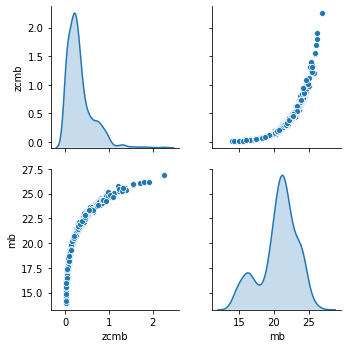

In [7]:
sns.pairplot(df, diag_kind="kde")

In [8]:
np.shape(dmag), np.shape(cov)
np.diag_indices_from(cov)

(array([   0,    1,    2, ..., 1045, 1046, 1047]),
 array([   0,    1,    2, ..., 1045, 1046, 1047]))

In [9]:
cov[np.diag_indices_from(cov)] += dmag**2
xdiag = 1/cov.diagonal() 

In [10]:
sq_errors = np.diag(syscov)
print(np.shape(sq_errors), type(sq_errors))

(1048,) <class 'numpy.ndarray'>


In [11]:
df['errors'] = np.sqrt(sq_errors+dmag**2)
df.describe()

,zcmb,mb,errors
count,1048.000000,1048.000000,1048.000000
mean,0.322365,20.747108,0.142484
std,0.285995,2.647864,0.031643
min,0.010120,13.907450,0.086315
25%,0.131935,19.607525,0.120915
50%,0.248800,21.159450,0.137935
75%,0.422958,22.479638,0.156516
max,2.260000,26.877000,0.451069


In [12]:
# df['mb'] += 19.36

(0.0, 2.3)

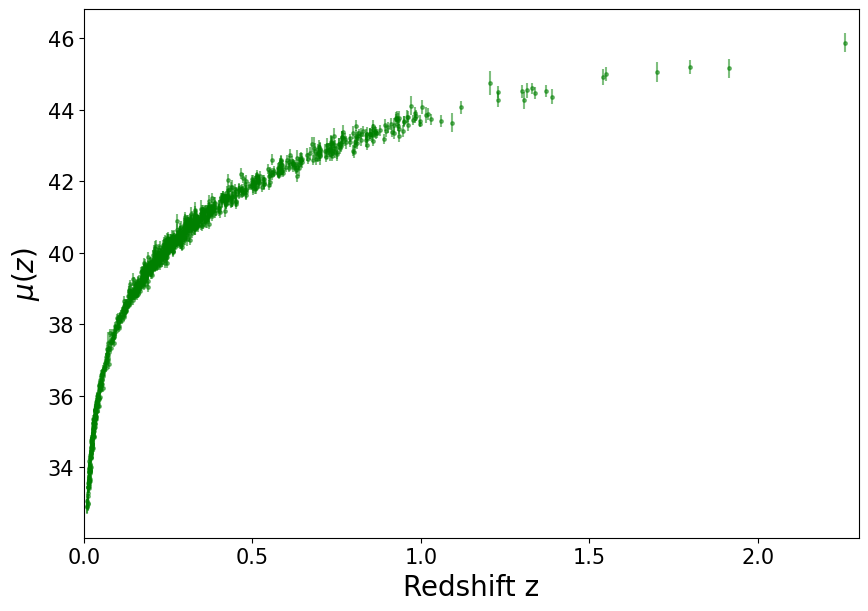

In [31]:
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(df['zcmb'], df['mb']+19, df['errors'], fmt='g.', markersize=5, label='Observations', alpha=0.5)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.xscale('log')


plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlim(0, 2.3)

In [14]:
randomize = np.random.permutation(N)
data = df.values[randomize]

In [15]:
z = data[:,0]
y = data[:,1:]
# print(randomize)

In [16]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

# scalery = MinMaxScaler(feature_range=(0,1))
# scalery = StandardScaler()
# scalery.fit(y)
# y = scalery.transform(y)

In [17]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [18]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0,
                                   patience=50.0,
                                   restore_best_weights=True)]
#                      tf.keras.callbacks.ReduceLROnPlateau(patience=2)]

In [19]:
def model(input_z):
    efirst = Dense(50, activation='relu', input_shape=(1,))(input_z)
    ehidden = Dense(200, activation='relu')(efirst)
    ehidden2 = Dense(150, activation='relu')(ehidden)
    elast = Dense(2, activation='linear')(ehidden2)


    return elast


input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 50)                100       
_________________________________________________________________
dense_1 (Dense)              (None, 200)               10200     
_________________________________________________________________
dense_2 (Dense)              (None, 150)               30150     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 302       
Total params: 40,752
Trainable params: 40,752
Non-trainable params: 0
_________________________________________________________________


In [20]:
batch_size = 4
epochs = 100
input_z = Input(shape = (1,))

In [21]:
model_train = neural_model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, y_test))
#                                     callbacks=callbacks)

Train on 838 samples, validate on 210 samples
Epoch 1/100
838/838 [==============================] - 1s 1ms/sample - loss: 46.8966 - val_loss: 4.8457
Epoch 2/100
838/838 [==============================] - 0s 496us/sample - loss: 1.5913 - val_loss: 0.2362
Epoch 3/100
838/838 [==============================] - 0s 513us/sample - loss: 0.2342 - val_loss: 0.1799
Epoch 4/100
838/838 [==============================] - 1s 611us/sample - loss: 0.1767 - val_loss: 0.1549
Epoch 5/100
838/838 [==============================] - 0s 527us/sample - loss: 0.1485 - val_loss: 0.1419
Epoch 6/100
838/838 [==============================] - 0s 469us/sample - loss: 0.1327 - val_loss: 0.1413
Epoch 7/100
838/838 [==============================] - 0s 517us/sample - loss: 0.1196 - val_loss: 0.0760
Epoch 8/100
838/838 [==============================] - 0s 510us/sample - loss: 0.0883 - val_loss: 0.0981
Epoch 9/100
838/838 [==============================] - 0s 464us/sample - loss: 0.0803 - val_loss: 0.0560
Epoch 10/1

Epoch 78/100
838/838 [==============================] - 0s 456us/sample - loss: 0.0765 - val_loss: 0.0233
Epoch 79/100
838/838 [==============================] - 0s 496us/sample - loss: 0.0464 - val_loss: 0.0468
Epoch 80/100
838/838 [==============================] - 0s 440us/sample - loss: 0.1333 - val_loss: 0.0775
Epoch 81/100
838/838 [==============================] - 0s 446us/sample - loss: 0.0388 - val_loss: 0.0242
Epoch 82/100
838/838 [==============================] - 0s 469us/sample - loss: 0.0303 - val_loss: 0.0486
Epoch 83/100
838/838 [==============================] - 0s 447us/sample - loss: 0.0388 - val_loss: 0.0184
Epoch 84/100
838/838 [==============================] - 0s 463us/sample - loss: 0.0287 - val_loss: 0.0301
Epoch 85/100
838/838 [==============================] - 0s 452us/sample - loss: 0.0436 - val_loss: 0.0296
Epoch 86/100
838/838 [==============================] - 0s 471us/sample - loss: 0.0309 - val_loss: 0.0225
Epoch 87/100
838/838 [========================

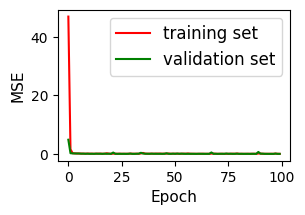

In [22]:
plt.figure(figsize=(3, 2), dpi=100)

plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
# plt.savefig('loss_hz.png')

In [23]:
# neural_model.save('FFNN_Hz.h5')

In [24]:
pred = neural_model.predict(z_test)
pred

array([[21.836983  ,  0.16007781],
       [21.009424  ,  0.1529166 ],
       [16.32013   ,  0.14510721],
       [22.0884    ,  0.16215733],
       [21.429892  ,  0.15680064],
       [23.265064  ,  0.1729897 ],
       [23.25888   ,  0.1729246 ],
       [21.945007  ,  0.16095264],
       [24.338562  ,  0.19798338],
       [15.173166  ,  0.15546829],
       [23.963987  ,  0.1875239 ],
       [15.900441  ,  0.14895502],
       [14.94443   ,  0.15747473],
       [22.930735  ,  0.169511  ],
       [17.16313   ,  0.13714278],
       [20.56331   ,  0.14802416],
       [21.963789  ,  0.16110426],
       [15.15578   ,  0.1556208 ],
       [20.97028   ,  0.1524885 ],
       [20.776096  ,  0.15036696],
       [15.745818  ,  0.15037265],
       [21.569246  ,  0.15791954],
       [23.04237   ,  0.1706658 ],
       [19.116308  ,  0.13002954],
       [21.043404  ,  0.15328786],
       [19.680416  ,  0.13446328],
       [22.88338   ,  0.16902135],
       [23.885471  ,  0.18593967],
       [22.548079  ,

In [32]:
# ranz = np.random.uniform(0, 2, size=10000)
ranz = np.linspace(0, 2.5, 1000)
r = scalerz.transform(ranz.reshape(-1, 1))
pred_random = neural_model.predict(r)
rr = scalerz.inverse_transform(r.reshape(-1,1))

(0.0, 2.3)

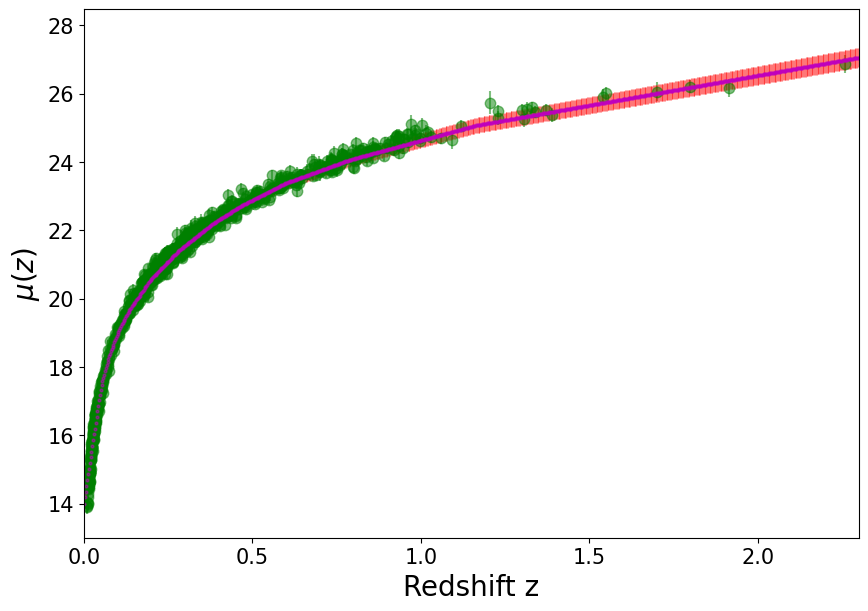

In [33]:
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(df['zcmb'], df['mb'], df['errors'], fmt='g.', markersize=15, label='Observations', alpha=0.5)
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.5, c='m')
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlim(0, 2.3)
# plt.savefig("20_epochs_HD.png")

In [34]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 2.4, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

#     fowacdm1.append(distance_modulus(zzz, w0=-1.3, wa=1.2))
#     fowacdm1.append(distance_modulus(zzz, w0=-1.09, wa=0.3, Om=om))
#     fowacdm2.append(distance_modulus(zzz, w0=-1.04, wa=-0.3, Om=om))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
# fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

Text(0.5, 0, 'Redshift $z$')

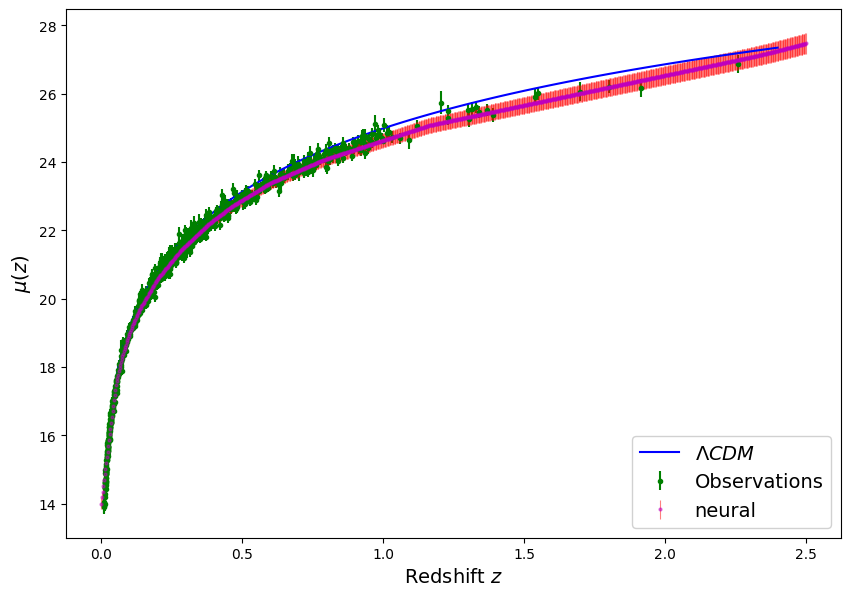

In [35]:
plt.figure(figsize=(10, 7), dpi=100)

plt.errorbar(df['zcmb'], df['mb'], yerr=df['errors'], fmt='g.', label='Observations')
# plt.plot(df['zcmb'], df['mb'], c='g')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.5, c='m', label='neural')
plt.ylabel("$\mu(z)$", fontsize=14)
plt.legend(fontsize=14, loc='lower right', framealpha=0.9, ncol=1)

                            


plt.xlabel('Redshift $z$', fontsize=14)



In [36]:
def model2(input_z):
    x = Dense(50, activation='relu', input_shape=(1,))(input_z)
    x = Dense(200, activation='relu')(x)
    x = Dense(150, activation='relu')(x)
    elast = Dense(2, activation='linear')(x)


    return elast


input_z = Input(shape = (1,))
neural_model2 = Model(input_z, model2(input_z))
neural_model2.compile(loss='mean_squared_error', optimizer = "adam")
neural_model2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_8 (Dense)              (None, 50)                100       
_________________________________________________________________
dense_9 (Dense)              (None, 200)               10200     
_________________________________________________________________
dense_10 (Dense)             (None, 150)               30150     
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 302       
Total params: 40,752
Trainable params: 40,752
Non-trainable params: 0
_________________________________________________________________


#### Ahora usando incertidumbres de la red con Monte Carlo Dropout

In [37]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.8
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((838, 1), (838, 1), (210, 1), (210, 1))

In [ ]:
from astroNN.nn.layers import MCDropout

In [ ]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 4
# optimizer = Adam(lr=.005)
optimizer = Adam(lr=0.0001)


# Compile Keras model
model = model_regression_dropout(num_hidden=[50, 200, 150])
model.compile(loss='mse', optimizer=optimizer) 
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model2_train = model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=800,verbose=1,
                                    validation_data=(z_test, y_test))

In [ ]:
# Generate test data
test_batch_size = 1000
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(0, 2., test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)

In [ ]:
np.mean(std_mc_dropout[:,0]), np.mean(std_mc_dropout[:,1])

In [ ]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(df['zcmb'], df['mb'], df['errors'], fmt='g.', markersize=10, label='Observations')
plt.errorbar(x_test, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='Synthetic data with $\sigma$')

plt.xlim(0,2)

# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()


In [ ]:
 prediction_mc_dropout[0,:]

In [ ]:
plt.figure(figsize=(3, 2), dpi=100)

plt.plot(model2_train.history['loss'], color='r', )
plt.plot(model2_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.xticks([])
plt.yticks([])


In [ ]:
# model.save('FFNN+MC-DO_Hz.h5')
# tf.keras.models.save_model(neural_model2, '../models/FFNN_MC_DO.h5' )

In [ ]:
mookdp = np.concatenate((x_test.reshape(-1,1), prediction_mc_dropout), axis=1)

# np.savetxt("data.dat",mookdp, delimiter=" ")

In [ ]:
dfMook = pd.DataFrame(mookdp, columns=['z', 'Hz', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("50hdmookdropout.png")